In [31]:
import pandas as pd

# Use double backslashes or a raw string to ensure the correct path
file_path = r"C:\\Users\\Admin\\Downloads\\sp500_stocks.csv"

# Load the file
df = pd.read_csv(file_path)

# Display the first few rows to confirm
df.head()


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,44.016724,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,43.741024,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,44.361340,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,44.393173,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,44.705978,70.501671,70.501671,69.648827,69.974915,4073337.0


In [32]:
print(df.isnull().sum())

Date              0
Symbol            0
Adj Close    101626
Close        101626
High         101626
Low          101626
Open         101626
Volume       101626
dtype: int64


In [33]:
# Sort by Date for calculating features correctly
df = df.sort_values(by='Date')

# Percentage change in 'Adj Close' (for price prediction)
df['Pct_Change'] = df['Adj Close'].pct_change()

# 7-day moving average of 'Adj Close'
df['MA_7'] = df['Adj Close'].rolling(window=7).mean()

# 30-day moving average of 'Adj Close'
df['MA_30'] = df['Adj Close'].rolling(window=30).mean()

# Rolling volatility (standard deviation over a window)
df['Volatility_30'] = df['Adj Close'].rolling(window=30).std()

# Drop missing values caused by rolling calculations
df = df.dropna()

# Inspect the new columns
print(df[['Date', 'Adj Close', 'Pct_Change', 'MA_7', 'MA_30', 'Volatility_30']].head())


C:\Users\Admin\AppData\Local\Temp\ipykernel_4812\4249648683.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Pct_Change'] = df['Adj Close'].pct_change()


               Date  Adj Close  Pct_Change       MA_7      MA_30  \
1083395  2010-01-06   9.950000    1.966459  25.324631  26.702643   
1463141  2010-01-06  65.939095    5.627045  28.782882  26.381763   
409532   2010-01-06  31.087502   -0.528542  32.464668  26.817795   
740879   2010-01-06  19.885469   -0.360339  32.282605  26.992687   
1831727  2010-01-20  35.531826    0.445208  24.317115  22.399006   

         Volatility_30  
1083395      18.975440  
1463141      18.185616  
409532       18.134629  
740879       18.038167  
1831727      12.010967  


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Features for regression
X = df[['Pct_Change', 'MA_7', 'MA_30', 'Volatility_30']]
y = df['Adj Close']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
regressor = LinearRegression()

# Fit the model to the training data
regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Example: Predicting stock price for the next day
future_predictions = regressor.predict(X_test[:5])  # Replace X_test[:5] with actual future data for real prediction
print(f"Predicted future prices: {future_predictions}")


Mean Squared Error: 68074.13617969694
Predicted future prices: [101.24602652  91.10417365  92.17640046 131.82205136 245.90648124]


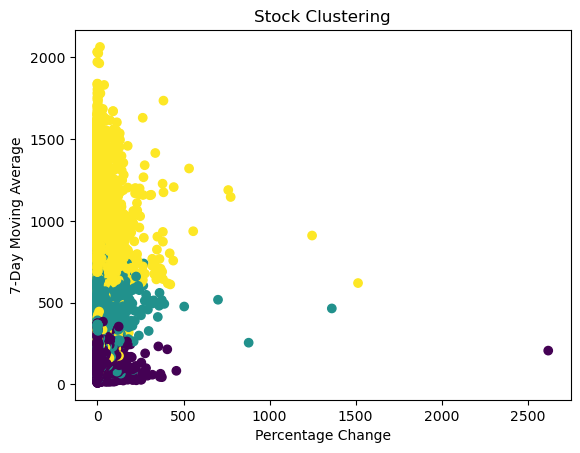

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select features for clustering
X_clustering = df[['Pct_Change', 'MA_7', 'Volatility_30']]

# Initialize KMeans (e.g., 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the data
df['Cluster'] = kmeans.fit_predict(X_clustering)

# Visualize the clusters
plt.scatter(df['Pct_Change'], df['MA_7'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Percentage Change')
plt.ylabel('7-Day Moving Average')
plt.title('Stock Clustering')
plt.show()


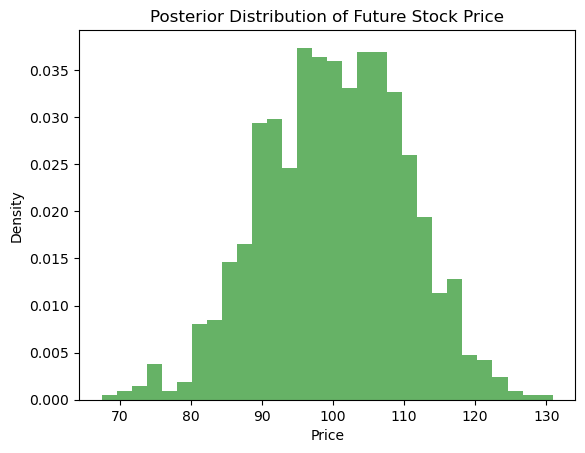

Predicted Stock Price: 100.2718437094757


In [38]:
import numpy as np
from scipy.stats import norm

# Hypothetical prior distribution for stock price
mu_prior = 100  # Prior belief: average price
sigma_prior = 10  # Prior belief: uncertainty in price

# Assume likelihood (based on new data)
mu_likelihood = df['Adj Close'].mean()  # From the historical data
sigma_likelihood = df['Adj Close'].std()  # Standard deviation of the data

# Update the posterior using Bayesian update (combining prior and likelihood)
mu_posterior = (mu_prior / sigma_prior**2 + mu_likelihood / sigma_likelihood**2) / (1/sigma_prior**2 + 1/sigma_likelihood**2)
sigma_posterior = np.sqrt(1 / (1/sigma_prior**2 + 1/sigma_likelihood**2))

# Generate future stock price predictions
posterior_samples = norm.rvs(mu_posterior, sigma_posterior, size=1000)

# Plot posterior distribution
import matplotlib.pyplot as plt
plt.hist(posterior_samples, bins=30, density=True, alpha=0.6, color='g')
plt.title('Posterior Distribution of Future Stock Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

# Use the posterior mean as the predicted price
predicted_price = np.mean(posterior_samples)
print(f"Predicted Stock Price: {predicted_price}")


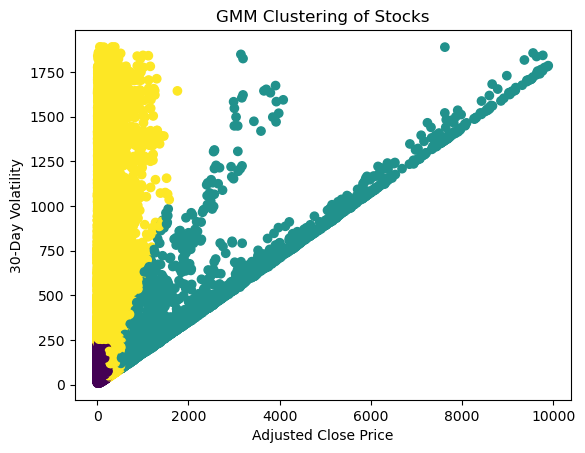

Means of the Gaussian components:
[[ 82.72275901 103.03485076]
 [934.67589858 223.22499752]
 [184.44795899 398.42963899]]
Covariances of the Gaussian components:
[[[ 3.19220384e+03  5.10249569e+02]
  [ 5.10249569e+02  2.36319322e+03]]

 [[ 1.38715232e+06  2.36278522e+05]
  [ 2.36278522e+05  4.46715141e+04]]

 [[ 2.03792863e+04 -1.08459634e+04]
  [-1.08459634e+04  1.04907076e+05]]]


In [39]:
from sklearn.mixture import GaussianMixture

# Select features for clustering (e.g., adjusted close price, volatility, etc.)
X_clustering = df[['Adj Close', 'Volatility_30']]

# Initialize GMM with a chosen number of components (e.g., 3 clusters)
gmm = GaussianMixture(n_components=3, random_state=42)

# Fit the GMM model to the data
gmm.fit(X_clustering)

# Predict the clusters for each data point
df['Cluster'] = gmm.predict(X_clustering)

# Visualize the clustering results
plt.scatter(df['Adj Close'], df['Volatility_30'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Adjusted Close Price')
plt.ylabel('30-Day Volatility')
plt.title('GMM Clustering of Stocks')
plt.show()

# Output the mean and covariance of the Gaussian components
print("Means of the Gaussian components:")
print(gmm.means_)

print("Covariances of the Gaussian components:")
print(gmm.covariances_)


In [46]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np

# Define time_steps and features
time_steps = 60  # Number of previous time steps to use
features = 1     # Number of features (for univariate time series, set to 1)

# Sample LSTM model architecture
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, features)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary to check the architecture
model.summary()


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
import xgboost as xgb

# Prepare data for XGBoost
X = df[features]  # Features
y = df['Adj Close']  # Target variable

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X, label=y)

# Define parameters and train the model
params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 5,
    'eta': 0.1,
    'eval_metric': 'rmse'
}

model = xgb.train(params, dtrain, num_boost_round=100)


In [67]:
!pip install xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 320.0 kB/s eta 0:06:31
   ---------------------------------------- 0.1/124.9 MB 651.6 kB/s eta 0:03:12
   ---------------------------------------- 0.1/124.9 MB 717.5 kB/s eta 0:02:54
   ---------------------------------------- 0.1/124.9 MB 774.0 kB/s eta 0:02:42
   ---------------------------------------- 0.1/124.9 MB 774.0 kB/s eta 0:02:42
   ---------------------------------------- 0.1/124.9 MB 774.0 kB/s eta 0:02:42
   ---------------------------------------- 0.2/124.9 MB 565.6 kB/s eta 0:03:41
   ---------------------------------------- 0.3/124.9 MB 655.4 kB/s eta 0:03:11
   ---------------------------------------- 0.3/124.9 MB 631.2 kB/s eta 0:03:18
   ---------------------------------------- 0.3/124.9 MB 631.2 kB/s eta 0:03:18
   ---------------------------------------- 0.3/124.9 MB 5

In [75]:
import xgboost as xgb

# Prepare data for XGBoost
X = df[features]  # Features
y = df['Adj Close']  # Target variable

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X, label=y)

# Define parameters and train the model
params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 5,
    'eta': 0.1,
    'eval_metric': 'rmse'
}

model = xgb.train(params, dtrain, num_boost_round=100)


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DMatrix for training and testing sets
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 85.70609548673228


In [79]:
# Make predictions on the entire dataset
y_pred = model.predict(dtrain)

# Print out some predictions (first 5 values)
print("Predicted stock prices:", y_pred[:5])


Predicted stock prices: [ 95.50506  124.44012  125.72065   66.575645  69.82401 ]


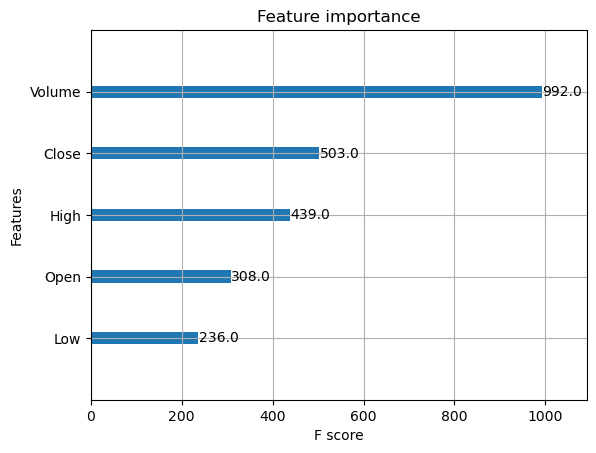

In [81]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(model)
plt.show()


In [83]:
# Check how many unique stock symbols are present
unique_stocks = df['Symbol'].nunique()
print(f"Number of unique stocks: {unique_stocks}")

# Print the list of unique stock symbols
print("Stock symbols:", df['Symbol'].unique())


Number of unique stocks: 503
Stock symbols: ['LYV' 'RL' 'C' 'FMC' 'WDC' 'SYY' 'SJM' 'HD' 'ROK' 'ISRG' 'TEL' 'MCO'
 'MRO' 'EXPD' 'LDOS' 'GILD' 'LLY' 'DRI' 'WFC' 'SBAC' 'PH' 'CDNS' 'JNJ'
 'DE' 'DUK' 'K' 'HBAN' 'ERIE' 'WBD' 'EMR' 'NRG' 'DG' 'HUM' 'BAX' 'AES'
 'FSLR' 'O' 'MKC' 'KEY' 'UDR' 'DXCM' 'BRO' 'RCL' 'CSGP' 'AMGN' 'PRU' 'TMO'
 'PCG' 'WMT' 'PARA' 'LUV' 'VRTX' 'IFF' 'DVN' 'QCOM' 'GWW' 'AOS' 'PEP'
 'KMB' 'NEE' 'FITB' 'ACGL' 'LEN' 'VZ' 'IVZ' 'PSA' 'ROP' 'MNST' 'CRL' 'HST'
 'BBY' 'PNR' 'PPG' 'HES' 'AEP' 'CNP' 'FI' 'ZBH' 'TAP' 'WAB' 'ACN' 'CSX'
 'ROST' 'FFIV' 'NUE' 'MET' 'ITW' 'ZBRA' 'APD' 'ED' 'PFG' 'IEX' 'CL' 'UAL'
 'PKG' 'VTRS' 'DOC' 'TDG' 'PGR' 'AMZN' 'ICE' 'PTC' 'PFE' 'CLX' 'JCI' 'PWR'
 'APH' 'NDAQ' 'JPM' 'TXN' 'NTAP' 'LHX' 'DECK' 'DHI' 'EXR' 'SWKS' 'NSC'
 'MCK' 'PAYX' 'TTWO' 'BMY' 'GEN' 'EFX' 'DLTR' 'MAS' 'ADBE' 'MMC' 'SNPS'
 'VMC' 'EXPE' 'IPG' 'EMN' 'CINF' 'SCHW' 'DOV' 'RJF' 'HPQ' 'ADI' 'WELL'
 'EXC' 'BDX' 'KDP' 'BK' 'WY' 'BRK-B' 'MTCH' 'TFX' 'BKNG' 'MO' 'NVR' 'MGM'
 'COST' 'SBUX' 

In [85]:
# Filter data for a specific stock symbol, e.g., 'MMM'
df_mmm = df[df['Symbol'] == 'MMM']

# Now you can proceed with your analysis on df_mmm
